### Goal: create a model to predict how many downloads a particular book title might get based on training data.

In [5]:
import pprint
import re
import random
import glob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn import svm
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
import ssl
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [6]:
'''
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download()
'''

'\ntry:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\n#nltk.download()\n'

In [254]:
graph_label_font_size = 16

In [7]:
adventure_text_files = glob.glob('books/Adventure/*.txt')
adventure_csv_files = glob.glob('books/Adventure/*.csv')

gothic_text_files = glob.glob('books/Gothic Fiction/*.txt')
gothic_csv_files = glob.glob('books/Gothic Fiction/*.csv')

horror_text_files = glob.glob('books/Horror/*.txt')
horror_csv_files = glob.glob('books/Horror/*.csv')

humor_text_files = glob.glob('books/Humor/*.txt')
humor_csv_files = glob.glob('books/Humor/*.csv')

mystery_text_files = glob.glob('books/Mystery Fiction/*.txt')
mystery_csv_files = glob.glob('books/Mystery Fiction/*.csv')

scifi_text_files = glob.glob('books/Science Fiction/*.txt')
scifi_csv_files = glob.glob('books/Science Fiction/*.csv')

western_text_files = glob.glob('books/Western/*.txt')
western_csv_files = glob.glob('books/Western/*.csv')

In [8]:
print('adventure: ',len(adventure_text_files), len(adventure_csv_files))
print('gothic: ',len(gothic_text_files), len(gothic_csv_files))
print('horror: ',len(horror_text_files), len(horror_csv_files))
print('humor: ',len(humor_text_files), len(humor_csv_files))
print('mystery: ',len(mystery_text_files), len(mystery_csv_files))
print('scifi: ',len(scifi_text_files), len(scifi_csv_files))
print('western: ',len(western_text_files), len(western_csv_files))

adventure:  75 74
gothic:  26 25
horror:  42 41
humor:  163 162
mystery:  14 13
scifi:  950 949
western:  92 91


### Use Scifi since we need a lot of titles for a good model

In [9]:
stop_words_list = stopwords.words('English')

In [10]:
def removeStopWords(text, stop_words_list):
    split_string = text.split(' ')
    result = ''
    for word in split_string:
        if word in stop_words_list:
            continue
        else:
            result += word + ' '
    return result.strip()

In [11]:
removeStopWords("Think Yourself to Death", stop_words_list)

'Think Yourself Death'

In [12]:
def clean_text(input_text):
    # remove text after return character
    text = input_text.split('\r')[0]
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    
    # remove numbers including unsigned / signed integers and floats
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(r"[-0-9]+", "", text)
    text = re.sub(r"[+.0-9]+", "", text)
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    # remove url text
    text = re.sub(r"(http)*", "", text)
    text = re.sub(r"(www)*", "", text)
    
    # remove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]+','', text)
    
    # remove stopwords
    text = removeStopWords(text, stop_words_list)

    return text

In [13]:
clean_text('The Goddess of Atvatabar\rBeing the history of the discovery of the interior world and conquest of Atvatabar')

'goddess atvatabar'

In [14]:
clean_text("Think Yourself to Death")

'think death'

In [15]:
def getTitleAndDownloadsFromMetaData(meta_data, clean_data):
    title_and_downloads = pd.DataFrame(columns=['Title', 'Downloads'])
    title = ''
    downloads = 0
    for index, row in meta_data.iterrows():
        if row[0].lower() == 'title':
            title = row[1].strip()
            if clean_data:
                title = clean_text(title)
        if row[0].lower() == 'downloads':
            number_of_downloads = re.search(r'\d+', row[1]).group().strip()
            downloads = int (number_of_downloads)
    title_and_downloads = title_and_downloads.append({'Title': title, 'Downloads': downloads}, ignore_index=True)
    return title_and_downloads

In [16]:
scifi_books_title_downloads = pd.DataFrame(columns=['Title', 'Downloads'])
for book_meta_data in scifi_csv_files:
    meta_data = pd.read_csv(book_meta_data, header=0)
    parsed_meta_data = getTitleAndDownloadsFromMetaData(meta_data, True)
    scifi_books_title_downloads = scifi_books_title_downloads.append(parsed_meta_data, ignore_index=True)

scifi_books_title_downloads.Downloads = pd.to_numeric(scifi_books_title_downloads.Downloads)
scifi_books_title_downloads.head()

,Title,Downloads
0,wolfbane,174
1,trace memory,111
2,fair planet,44
3,new lamps,78
4,think death,74


In [22]:
scifi_books_title_downloads.shape

(949, 2)

In [23]:
scifi_books_title_downloads_uncleaned = pd.DataFrame(columns=['Title', 'Downloads'])
for book_meta_data in scifi_csv_files:
    meta_data = pd.read_csv(book_meta_data, header=0)
    parsed_meta_data = getTitleAndDownloadsFromMetaData(meta_data, False)
    scifi_books_title_downloads_uncleaned = scifi_books_title_downloads.append(parsed_meta_data, ignore_index=True)

scifi_books_title_downloads_uncleaned.Downloads = pd.to_numeric(scifi_books_title_downloads.Downloads)
print(scifi_books_title_downloads_uncleaned.shape)
scifi_books_title_downloads_uncleaned.head()

(950, 2)


,Title,Downloads
0,wolfbane,174.0
1,trace memory,111.0
2,fair planet,44.0
3,new lamps,78.0
4,think death,74.0


In [24]:
#scifi_books_title_downloads_uncleaned_filtered = scifi_books_title_downloads_uncleaned[
#    scifi_books_title_downloads_uncleaned.isna()
#]
scifi_books_title_downloads_uncleaned = scifi_books_title_downloads_uncleaned.dropna()
#scifi_books_title_downloads_uncleaned_filtered.shape
scifi_books_title_downloads_uncleaned.isnull()

,Title,Downloads
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
944,False,False
945,False,False
946,False,False
947,False,False


In [25]:
scifi_books_title_downloads.shape

(949, 2)

### Plot downloads to see if there are any clusters

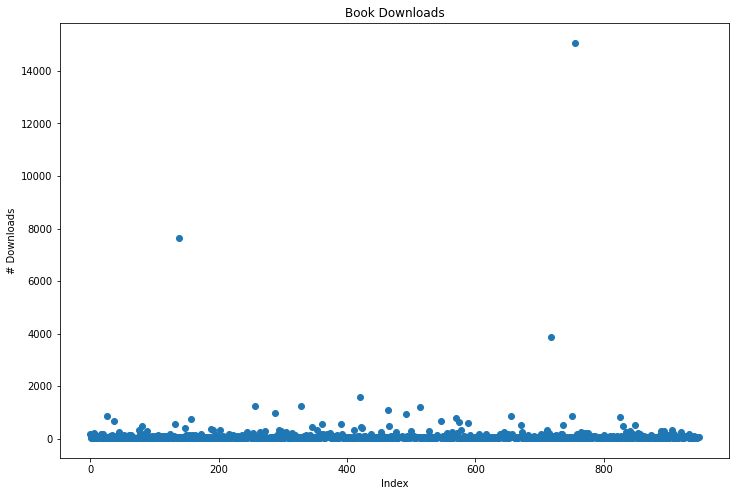

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(scifi_books_title_downloads.index, scifi_books_title_downloads.Downloads)
plt.title('Book Downloads')
plt.xlabel('Index')
plt.ylabel('# Downloads')
plt.show()

### looks like we have some outlier points. Remove rows that are 3 sigma away

In [27]:
def removeOutliers(df, columnsToIgnore):
    result = pd.DataFrame(df)
    for column in df.columns:
        if column in columnsToIgnore:
            print("ignoring column: {0}".format(column))
            continue
        # remove points that are greater than 3 sigma
        result = result[~(np.abs(df[column] - result[column].mean()) > (3 * result[column].std()))]
    
    return result

In [28]:
scifi_books_title_downloads_without_outliers = removeOutliers(scifi_books_title_downloads, 'Title')

ignoring column: Title


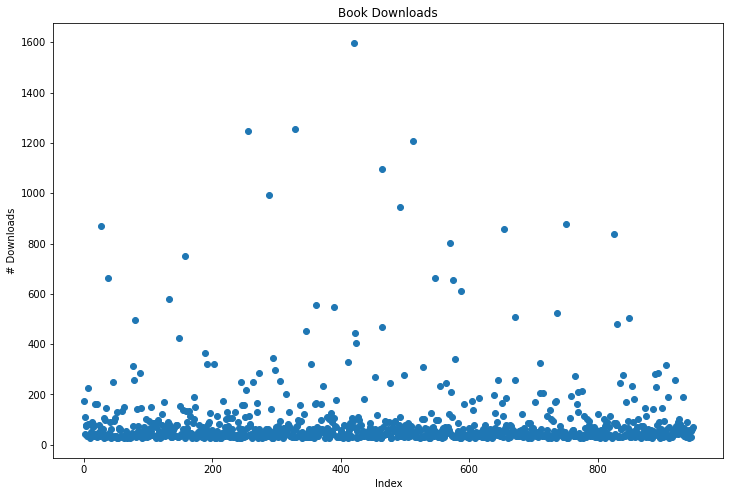

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(scifi_books_title_downloads_without_outliers.index, scifi_books_title_downloads_without_outliers.Downloads)
plt.title('Book Downloads')
plt.xlabel('Index')
plt.ylabel('# Downloads')
plt.show()

In [30]:
scifi_books_title_downloads_without_outliers.Downloads.max(), scifi_books_title_downloads_without_outliers.Downloads.min()

(1598, 27)

In [31]:
scifi_books_title_downloads_without_outliers.shape

(946, 2)

In [33]:
len(scifi_books_title_downloads_without_outliers.Title), len(scifi_books_title_downloads_without_outliers.Title.unique())

(946, 941)

### looks like there are no repititions, lets look at a histogram of top common words

In [34]:
def getCommonWords(df):
    common_words = {}
    for index, row in df.iterrows():
        title = row[0].strip()
        split_title = title.split(' ')
        for word in split_title:
            word = word.strip()
            if word == '':
                continue
            elif word in common_words.keys():
                common_words[word] += 1
            else:
                common_words[word] = 1
    return pd.DataFrame.from_dict({'Word': common_words.keys(), 'Count': common_words.values()})

In [35]:
word_count = getCommonWords(scifi_books_title_downloads_without_outliers)
word_count.head()

,Word,Count
0,wolfbane,1
1,trace,1
2,memory,3
3,fair,1
4,planet,26


In [36]:
sorted_word_counts = word_count.sort_values(by='Count', ascending=False)
sorted_word_counts.head()

,Word,Count
67,space,26
4,planet,26
215,world,24
35,stories,23
14,man,22


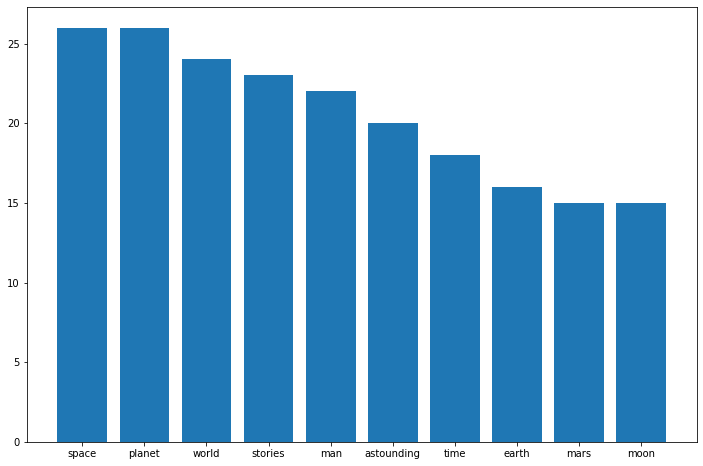

,Word,Count
67,space,26
4,planet,26
215,world,24
35,stories,23
14,man,22


In [42]:
number_of_top_words = 10
top_words = sorted_word_counts.head(number_of_top_words)
plt.figure(figsize=(12,8))
plt.bar(top_words.Word, top_words.Count)
plt.show()
top_words.head()

In [51]:
# plot of words vs downloads
# plot coefficients
# split into buckets and do linear regressions and show coef for top words
# Show that there is no correlation between book title and number of downloads

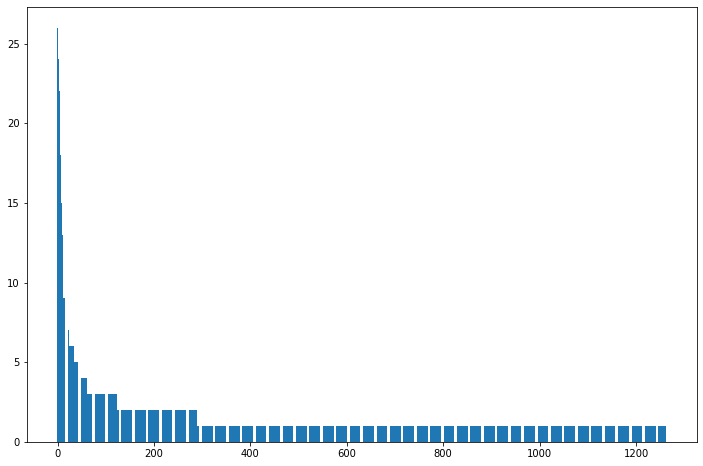

,Word,Count
67,space,26
4,planet,26
215,world,24
35,stories,23
14,man,22


In [44]:
display_indices = np.arange(0, len(sorted_word_counts.Count))
plt.figure(figsize=(12,8))
plt.bar(display_indices, sorted_word_counts.Count)
plt.show()
top_words.head()

In [46]:
scifi_books_title_downloads = scifi_books_title_downloads.sort_values(by='Downloads', ascending=False)
scifi_books_title_downloads.head()

,Title,Downloads
755,anthem,15071
138,war worlds,7623
718,b r b,3866
420,journey centre earth,1598
328,twenty thousand leagues seas underwater tour ...,1254


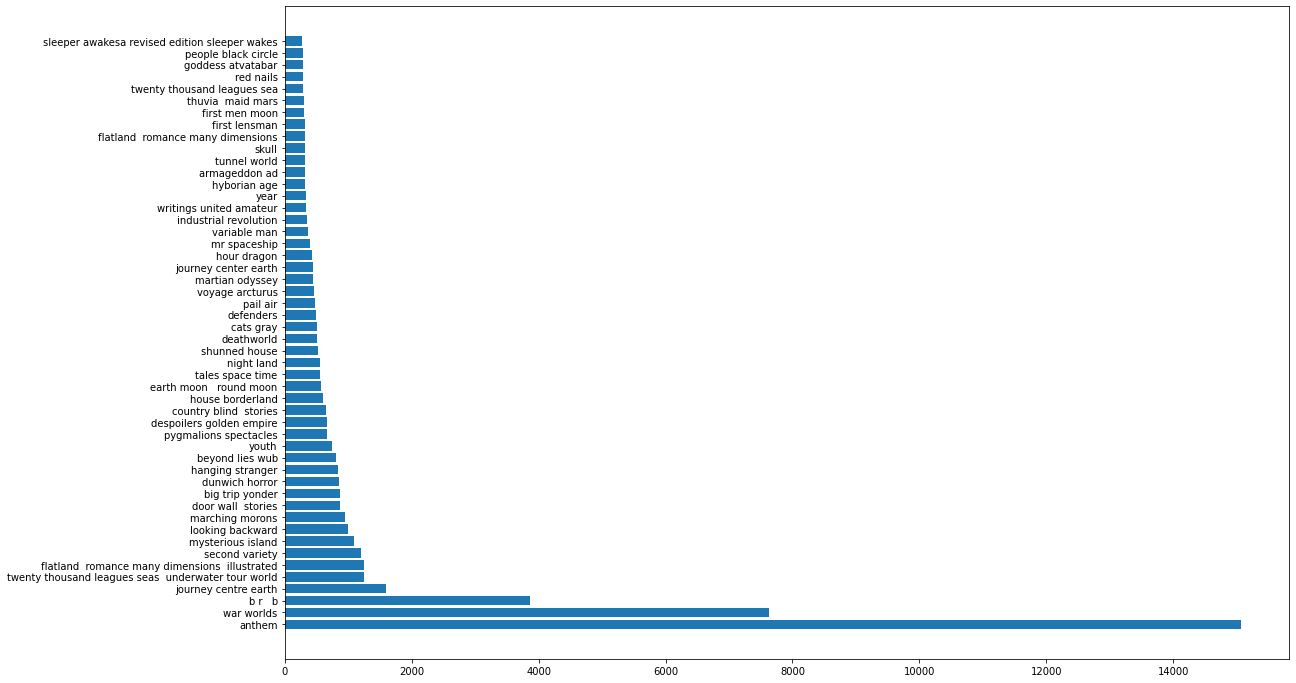

,Word,Count
67,space,26
4,planet,26
215,world,24
35,stories,23
14,man,22


In [114]:
top_titles_by_download = 50
top_titles = scifi_books_title_downloads.head(top_titles_by_download)
plt.figure(figsize=(18,12))
plt.barh(top_titles.Title, top_titles.Downloads)
plt.show()
top_words.head()

In [53]:
train_data, test_data = train_test_split(scifi_books_title_downloads, test_size = 0.3, random_state=42)
print(scifi_books_title_downloads.shape)
print(train_data.shape)
print(test_data.shape)
train_data.head()

(949, 2)
(664, 2)
(285, 2)


,Title,Downloads
381,pursuit,29
25,course,36
111,dictator,87
933,food gods came earth,190
251,third planet,111


In [115]:
vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             strip_accents="unicode")

In [116]:
train_label = train_data["Downloads"]
train_features = vectorizer.fit_transform(train_data["Title"])
test_label = test_data["Downloads"]
test_features = vectorizer.transform(test_data["Title"])
print(train_label.shape)
print(train_features.shape)
print(test_label.shape)
print(test_features.shape)

(664,)
(664, 931)
(285,)
(285, 931)


In [117]:
vectorizer.get_feature_names()

['abyss',
 'accidental',
 'acid',
 'action',
 'ad',
 'adolescents',
 'adventurer',
 'affair',
 'afternoon',
 'age',
 'agents',
 'aggravation',
 'air',
 'airlords',
 'alert',
 'alien',
 'aliens',
 'almanack',
 'aloys',
 'amateur',
 'amateurs',
 'amazon',
 'ambulance',
 'analogue',
 'ancestor',
 'anchorite',
 'andromeda',
 'angel',
 'angels',
 'anglers',
 'anthem',
 'apples',
 'april',
 'aptor',
 'arctic',
 'arcturus',
 'armageddon',
 'arret',
 'arthur',
 'arz',
 'ask',
 'assassin',
 'asses',
 'asteroid',
 'asti',
 'astounding',
 'atlantida',
 'atom',
 'attached',
 'attention',
 'attrition',
 'atvatabar',
 'august',
 'awakening',
 'bacillus',
 'backlash',
 'backward',
 'bad',
 'badge',
 'balaam',
 'balak',
 'bath',
 'battle',
 'bearing',
 'beast',
 'beginning',
 'belt',
 'best',
 'big',
 'billion',
 'black',
 'blaster',
 'blind',
 'blindmans',
 'blue',
 'bluff',
 'bobby',
 'bone',
 'boomer',
 'borderland',
 'born',
 'bottle',
 'bounce',
 'box',
 'brain',
 'brains',
 'bramble',
 'bread',


### Training

In [118]:
linear_regression_model = LinearRegression().fit(train_features, train_label)
linear_regression_model.score(test_features, test_label)
y_pred_0 = linear_regression_model.predict(test_features)

In [239]:
linear_regression_model.score(test_features, test_label)

-9.240825330783277

In [119]:
mean_squared_error(test_label, y_pred_0)

681203.2796243742

In [120]:
linear_regression_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [121]:
linear_regression_model.coef_

array([ 2.69637905e+02, -1.66165765e+00, -1.64924861e+01, -1.99924861e+01,
        1.25007514e+02, -2.79849726e+01,  1.30150274e+01, -1.49924861e+01,
       -1.89924861e+01,  7.43433517e+01,  3.75075138e+01, -1.94924861e+01,
        1.60209017e+02, -2.99248614e+00, -5.53972450e+02,  1.01502312e+00,
        6.40150274e+01, -5.99699434e+00, -3.98497263e+00,  9.00050093e+01,
       -3.59849726e+01, -2.39923857e+01, -5.49248614e+00, -1.69924861e+01,
       -4.38593846e+01, -1.99849726e+01,  2.00751386e+00,  4.56987947e+01,
       -6.99248614e+00, -1.44924861e+01,  1.50010150e+04, -1.11969946e+01,
        3.77108312e+01,  1.26716758e+01, -6.81778957e+00,  1.63637909e+02,
        1.25007514e+02, -3.09969947e+01, -8.49248614e+00, -1.44924861e+01,
        3.40050092e+01, -2.19849726e+01, -1.84924861e+01, -1.94924861e+01,
        5.60601110e+00, -1.35384799e+02, -1.49849726e+01, -7.21156061e+01,
       -8.49248614e+00, -1.33283242e+01, -3.89849726e+01,  1.07507514e+02,
       -1.25723029e+01, -

### Plot actual vs prediction labels

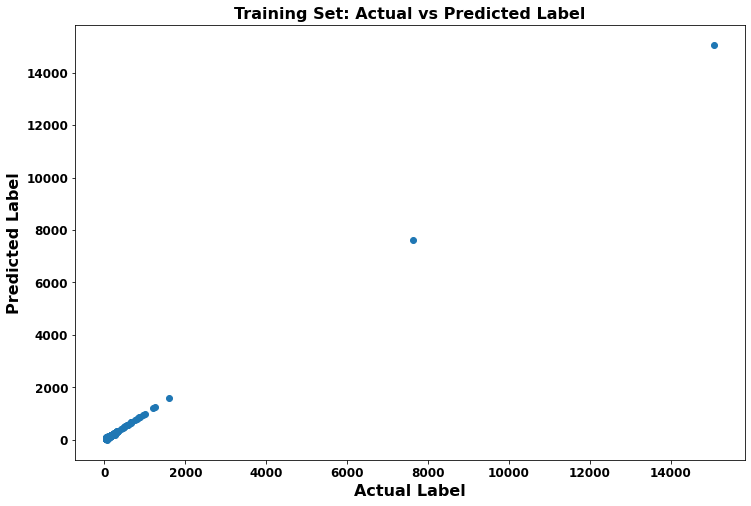

In [256]:
training_label_prediction = linear_regression_model.predict(train_features)
plt.figure(figsize=(12,8))
plt.scatter(train_label, training_label_prediction)
plt.title('Training Set: Actual vs Predicted Label', fontsize=graph_label_font_size, fontweight="bold")
plt.xlabel('Actual Label', fontsize=graph_label_font_size, fontweight="bold")
plt.ylabel('Predicted Label', fontsize=graph_label_font_size, fontweight="bold")
plt.show()

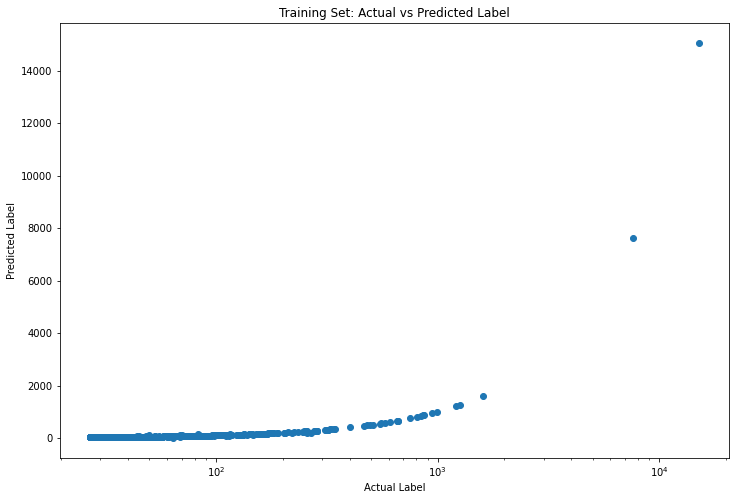

In [235]:
#ax.set_yscale('log')
training_label_prediction = linear_regression_model.predict(train_features)
plt.figure(figsize=(12,8))
plt.scatter(train_label, training_label_prediction)
plt.title('Training Set: Actual vs Predicted Label')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.xscale('log')
plt.show()

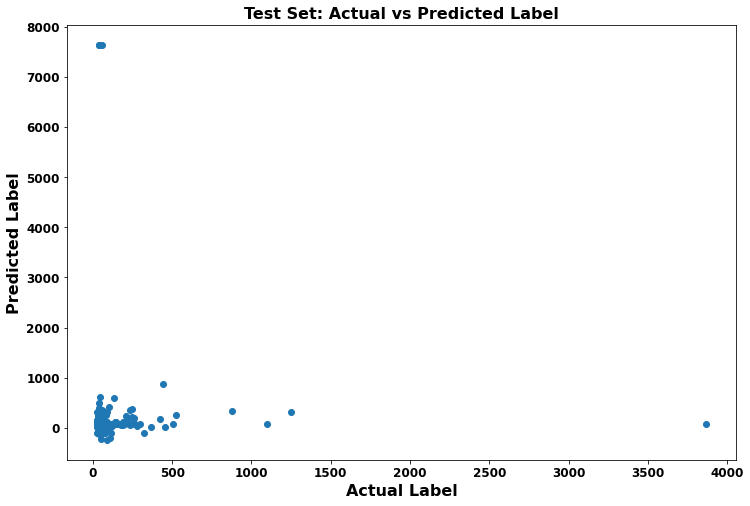

In [257]:
test_label_prediction = linear_regression_model.predict(test_features)
plt.figure(figsize=(12,8))
plt.scatter(test_label, test_label_prediction)
plt.title('Test Set: Actual vs Predicted Label', fontsize=graph_label_font_size, fontweight="bold")
plt.xlabel('Actual Label', fontsize=graph_label_font_size, fontweight="bold")
plt.ylabel('Predicted Label', fontsize=graph_label_font_size, fontweight="bold")
plt.show()

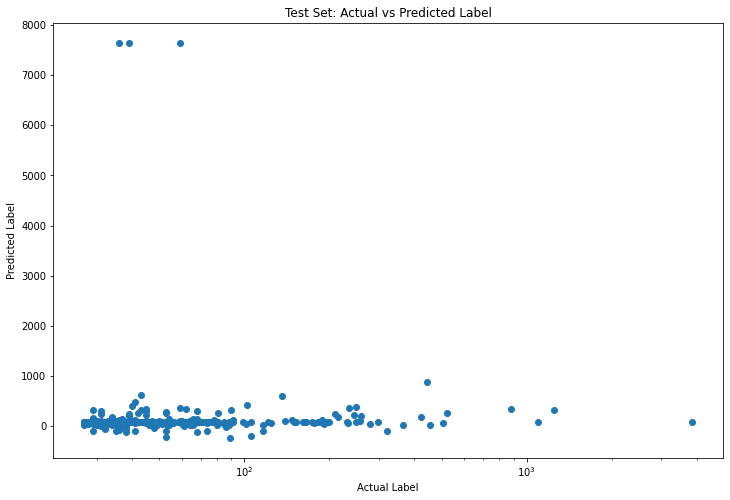

In [236]:
test_label_prediction = linear_regression_model.predict(test_features)
plt.figure(figsize=(12,8))
plt.scatter(test_label, test_label_prediction)
plt.title('Test Set: Actual vs Predicted Label')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.xscale('log')
plt.show()

### There does not seem to be correlation between titles and downloads, let us find a concrete example. 
### Check if we can find a word that has high downloads and low downloads find the worst predicted values and see if we can find something interesting

In [124]:
linear_regression_model.score(train_features, train_label)

0.9998717016028656

In [125]:
linear_regression_model.score(test_features, test_label)

-9.240825330783277

In [127]:
test_title = vectorizer.transform([clean_text("this is mars space")])
linear_regression_model.predict(test_title)[0]

123.67598706742996

In [128]:
test_title = vectorizer.transform([clean_text("Mystery")])
linear_regression_model.predict(test_title)[0]

-435.76656463059123

In [133]:
test_title = vectorizer.transform([clean_text("world")])
linear_regression_model.predict(test_title)[0]

-107.73407245183955

In [132]:
test_title = vectorizer.transform([clean_text("Anthem the first world mars")])
linear_regression_model.predict(test_title)[0]

14907.224188419445

### common words between top and bottom titles

In [209]:
def findCommonWords(top_book_titles, bottom_book_titles):
    result = pd.DataFrame(columns=['Matched_Word', 'Top_Downloads', 'Bottom_Downloads'])
    for top_index, top_row in top_book_titles.iterrows():
        top_title = top_row[0].strip().lower()
        top_split_title = top_title.split(' ')
        top_number_of_downloads = top_row[1]
        
        #print(top_title)

        for bottm_index, bottom_row in bottom_book_titles.iterrows():
            bottom_title = bottom_row[0].strip().lower()
            bottom_split_title = bottom_title.split(' ')
            bottom_number_of_downloads = bottom_row[1]
            
            match_found = False
            for bottom_word in bottom_split_title:
                #print(bottom_word.strip())
                if bottom_word.strip() != "" and bottom_word.strip() in top_split_title:
                    #print('Top Title/Downloads: {0} - {1}, Bottom Title/Downloads: {2} - {3}, Found Match: {2}'.format(
                    #    top_title,
                    #    top_number_of_downloads,
                    #    bottom_title,
                    #    bottom_number_of_downloads,
                    #    bottom_word)
                    #)
                    #print('Found Match: {0}'.format(bottom_word))
                    #print('Top Title: {0}'.format(top_title))
                    #print('Bottom Title: {0}'.format(bottom_title))
                    #match_found = True
                    
                    result = result.append({'Matched_Word': bottom_word, 'Top_Downloads': top_number_of_downloads, 'Bottom_Downloads': bottom_number_of_downloads}, ignore_index=True)
                    break
                else:
                    continue
            
            if match_found:
                break
    return result

In [210]:
top_n = 50
top_book_titles = scifi_books_title_downloads.head(top_n)
bottom_book_titles = scifi_books_title_downloads.tail(top_n)
common_words = findCommonWords(top_book_titles, bottom_book_titles)
common_words.head()

,Matched_Word,Top_Downloads,Bottom_Downloads
0,centre,1598,29
1,thousand,1254,29
2,wall,878,27
3,beyond,803,27
4,blind,654,28


No handles with labels found to put in legend.


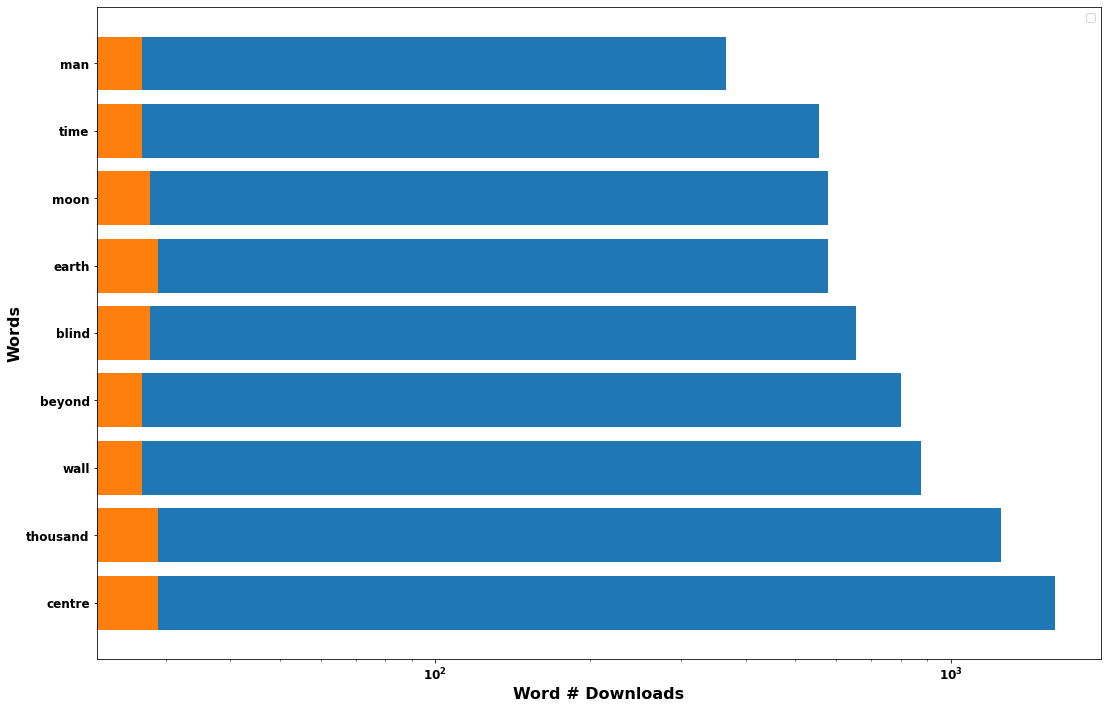

In [266]:
top_common_words_size = 10
top_common_words = common_words.head(top_common_words_size)
plt.figure(figsize=(18,12))
plt.barh(top_common_words.Matched_Word, top_common_words.Top_Downloads)
plt.barh(top_common_words.Matched_Word, top_common_words.Bottom_Downloads)
plt.xlabel('Word # Downloads', fontsize=graph_label_font_size, fontweight="bold")
plt.ylabel('Words', fontsize=graph_label_font_size, fontweight="bold")
plt.xscale('log')
plt.legend()
plt.show()

In [267]:
top_common_words

,Matched_Word,Top_Downloads,Bottom_Downloads
0,centre,1598,29
1,thousand,1254,29
2,wall,878,27
3,beyond,803,27
4,blind,654,28
5,earth,578,29
6,moon,578,28
7,time,556,27
8,earth,444,29
9,man,366,27


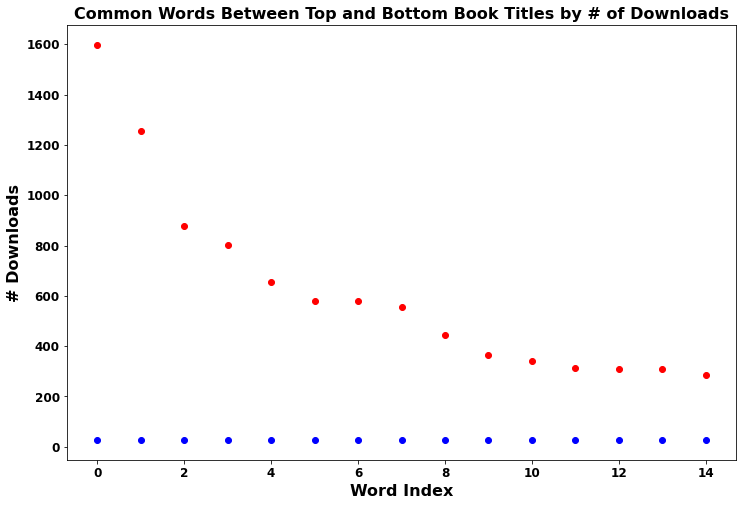

In [265]:
plt.figure(figsize=(12,8))
plt.scatter(common_words.index, common_words.Top_Downloads, color='r')
plt.scatter(common_words.index, common_words.Bottom_Downloads, color='b')
plt.title('Common Words Between Top and Bottom Book Titles by # of Downloads', fontsize=graph_label_font_size, fontweight="bold")
plt.xlabel('Word Index', fontsize=graph_label_font_size, fontweight="bold")
plt.ylabel('# Downloads', fontsize=graph_label_font_size, fontweight="bold")
plt.show()

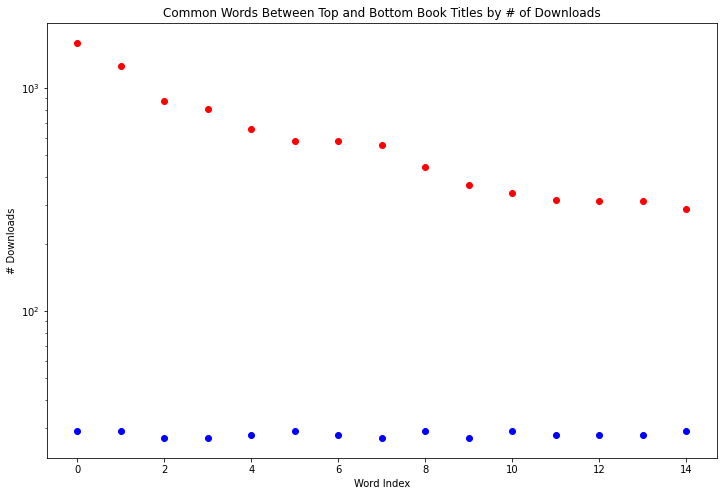

In [237]:
plt.figure(figsize=(12,8))
plt.scatter(common_words.index, common_words.Top_Downloads, color='r')
plt.scatter(common_words.index, common_words.Bottom_Downloads, color='b')
plt.title('Common Words Between Top and Bottom Book Titles by # of Downloads')
plt.xlabel('Word Index')
plt.ylabel('# Downloads')
plt.yscale('log')
plt.show()

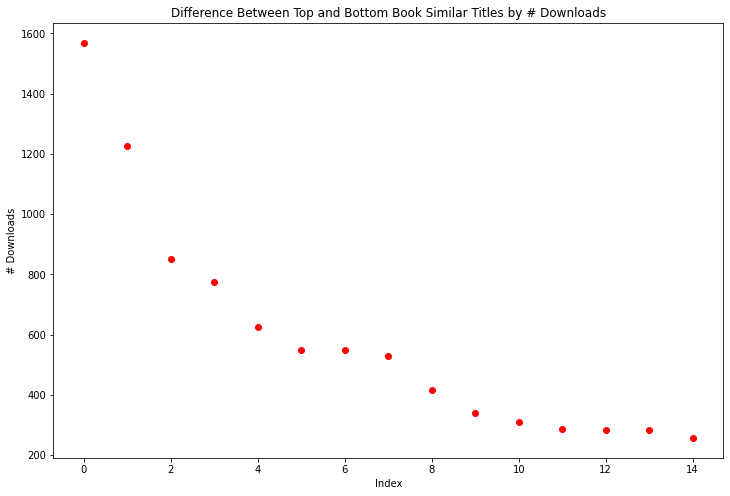

In [230]:
plt.figure(figsize=(12,8))
plt.scatter(common_words.index, abs(common_words.Top_Downloads - common_words.Bottom_Downloads), color='r')
plt.title('Difference Between Top and Bottom Book Similar Titles by # Downloads')
plt.xlabel('Index')
plt.ylabel('# Downloads')
plt.show()

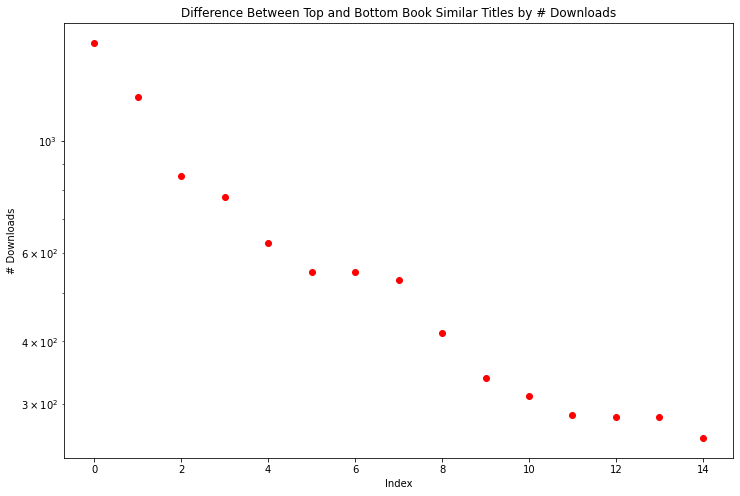

In [238]:
plt.figure(figsize=(12,8))
plt.scatter(common_words.index, abs(common_words.Top_Downloads - common_words.Bottom_Downloads), color='r')
plt.title('Difference Between Top and Bottom Book Similar Titles by # Downloads')
plt.xlabel('Index')
plt.ylabel('# Downloads')
plt.yscale('log')
plt.show()

In [226]:
test_title = vectorizer.transform([clean_text("this is mars space")])
'Predicted # Downloads: {0}'.format(linear_svc_model.predict(test_title)[0])

'Predicted # Downloads: 101'